# Using `load_ard` to load and cloud mask multiple satellite sensors

* **Products Used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr),
[ls7_sr](https://explorer.digitalearth.africa/ls7_sr),
[ls5_sr](https://explorer.digitalearth.africa/ls5_sr),
[s2_l2a](https://explorer.digitalearth.africa/s2a_l2a)

### Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations over Africa from multiple Landsat satellites (i.e. Landsat 5, 7 and 8) and Sentinel-2 satellites (i.e. Sentinel-2A and Sentinel-2B).
The function automatically applies cloud masking to the input data and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality non-cloudy or shadowed pixels.
This can be used to extract visually appealing time series of observations that are not affected by cloud.

The `load_ard` function currently supports the following products: 

* USGS Collection 2: `ls5_sr, ls7_sr, ls8_sr` 
* Sentinel 2: `s2_l2a`


This notebook demonstrates how to use `load_ard` to
1. Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
2. Optionally apply a cloud mask to the resulting data
3. Filter resulting data to keep only cloud-free observations
4. Filter data before loading using a custom function
5. Load Sentinel-2 data
6. Lazily load data using Dask

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import datacube.utils.rio

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube


In [2]:
# Connect to datacube 
dc = datacube.Datacube(app='Using_load_ard')

## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple Landsat satellites. 
At its simplest, you can use the function similarly to `dc.load` by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the dc.load documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that the function also requires an existing `Datacube` object, which is passed using the `dc` parameter. 
This gives us the flexibilty to load data from development or experimental datacubes.

In the examples below, we load three bands of data (`red`, `green`, `blue`) from the three USGS Collection 1 products (Landsat 5, 7 and 8) by specifying:

`products=['ls5_sr', 'ls7_sr', 'ls8_sr']`

The function always outputs the number of observations for each product, and the total number loaded.

### Explicit syntax
The following example demonstrates how key parameters can be passed directly to `load_ard`.

In [3]:
ds = load_ard(dc=dc,
              products=['ls5_sr',
                        'ls7_sr',
                        'ls8_sr'],
              x=(-16.45, -16.6),
              y=(13.675, 13.8),
              time=('2018-06', '2018-08'),
              measurements = ['red','green','blue'],
              output_crs='epsg:6933',
              resolution=(-30, 30),
              group_by='solar_day')

print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 6 time steps
<xarray.Dataset>
Dimensions:      (time: 6, x: 484, y: 517)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-09T11:26:17.457551 ... 2018-08...
  * y            (y) float64 1.744e+06 1.744e+06 ... 1.729e+06 1.728e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.587e+06 -1.587e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 nan nan nan ... 0.0718375 0.10052
    green        (time, y, x) float32 nan nan nan ... 0.08418499 0.11391251
    blue         (time, y, x) float32 nan nan nan ... 0.044200003 0.072909996
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Query syntax
The following example demonstrates how key parameters can be stored in a `query` dictionary, to be passed as a single parameter to `load_ard`.
The `query` can then be reused in other `load_ard` calls.

In [4]:
# Create a reusable query
query = {
    'x': (-16.45, -16.6),
    'y': (13.675, 13.8),
    'time': ('2018-06', '2018-08'),
    'measurements': ['red', 'green', 'blue'],
    'group_by': 'solar_day',
    'output_crs' : 'epsg:6933',
}

In [5]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc, 
              products=['ls5_sr',
                        'ls7_sr',
                        'ls8_sr'],
              resolution=(-30, 30),
              **query)

# Print output data
print(ds)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 6 time steps
<xarray.Dataset>
Dimensions:      (time: 6, x: 484, y: 517)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-09T11:26:17.457551 ... 2018-08...
  * y            (y) float64 1.744e+06 1.744e+06 ... 1.729e+06 1.728e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.587e+06 -1.587e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 nan nan nan ... 0.0718375 0.10052
    green        (time, y, x) float32 nan nan nan ... 0.08418499 0.11391251
    blue         (time, y, x) float32 nan nan nan ... 0.044200003 0.072909996
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Working with cloud masking
By plotting a time slice from the data we loaded above, you can see an area of white pixels where clouds have been masked out and set to `NaN`:

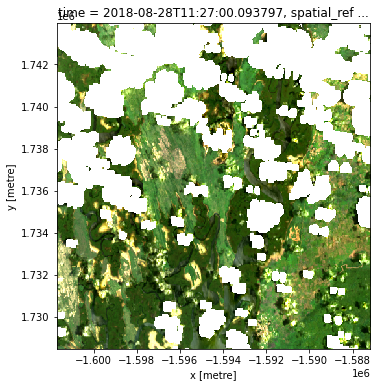

In [6]:
# Plot single observation
rgb(ds, index=5)


By default, `load_ard` applies a pixel quality mask to loaded data using the sensor's pixel quality band. 

For USGS Collection 2, the following mask parameters are applied to the `quality_l2_aerosol` band: 

```
{'cloud_shadow': 'not_cloud_shadow', 
'cloud_or_cirrus': 'not_cloud_or_cirrus', 
'nodata': False}
```

For Sentinel 2, the following mask parameters are applied to the [scl](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) band: 

```
['vegetation','snow or ice','water', 'bare soils', 'dark area pixels', 'unclassified']
```

> **Note:** These masking parameters can be customised using the `pq_categories_ls` parameter for USGS data, and the `pq_categories_s2` parameter for Sentinel 2 data

We can de-activate pixel masking completely by setting `mask_pixel_quality=False`:




Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Re-scaling Landsat C2 data
Loading 6 time steps


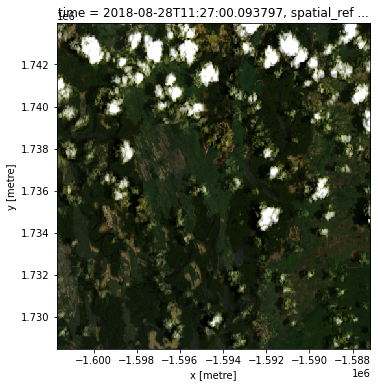

In [7]:
# Load available data with cloud masking deactivated
ds = load_ard(dc=dc, 
              products=['ls5_sr',
                        'ls7_sr',
                        'ls8_sr'],
              mask_pixel_quality=False, 
              resolution=(-30, 30),
              **query)

# Plot single observation
rgb(ds, index=5)


### Filtering to non-cloudy observations
In addition to masking out cloud, `load_ard` allows you to discard any satellite observation that contains less than a minimum proportion of good quality (e.g. non-cloudy) pixels.
This can be used to obtain a time series of only clear, cloud-free observations.

To discard all observations with less than `X`% good quality pixels, use the `min_gooddata` parameter. 
For example, `min_gooddata=0.99` will return only observations where less than 1% of pixels contain cloud, cloud shadow or other invalid data, resulting in a smaller number of clear, cloud free images being returned by the function:

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 1 time steps


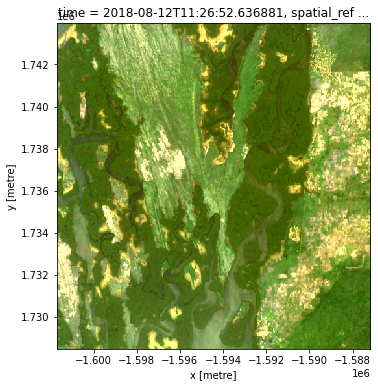

In [8]:
# Load available data filtered to 99% clear observations
ds = load_ard(dc=dc, 
              products=['ls5_sr',
                        'ls7_sr',
                        'ls8_sr'],
              min_gooddata=0.99, 
              resolution=(-30, 30),
              **query)

# Plot single observation
rgb(ds, index=0)


## Filtering data before load using a custom function
The `load_ard` function has a powerful predicate parameter that allows you to filter out satellite observations before they are actually loaded using a custom function. Some examples of where this may be useful include:

* Filtering to return data from a specific season (e.g. summer, winter)
* Filtering to return data acquired on a particular day of the year
* Filtering to return data based on an external dataset (e.g. data acquired during specific climatic conditions such as drought or flood)

A predicate function should take a `datacube.model.Dataset` object as an input (e.g. as returned from `dc.find_datasets(product='ls8_sr', **query)[0]`, and return either `True` or `False`. For example, a predicate function could be used to return True for only datasets acquired in April:

`dataset.time.begin.month == 4`

### Filter to a single month
In the example below, we create a simple predicate function that will filter our data to return only satellite data acquired in April:

In [9]:
def filter_april(dataset):
    return dataset.time.begin.month == 4

# Load data that passes the `filter_april` function
ds = load_ard(dc=dc, 
             products=['ls5_sr',
                        'ls7_sr',
                        'ls8_sr'], 
              x=(-16.45, -16.6),
              y=(13.675, 13.8),
              time=('2016', '2018'),
              measurements = ['red', 'green', 'blue'],
              output_crs='epsg:6933',
              predicate=filter_april,
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Filtering datasets using filter function
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 5 time steps
<xarray.Dataset>
Dimensions:      (time: 5, x: 484, y: 517)
Coordinates:
  * time         (time) datetime64[ns] 2016-04-16T11:27:02.825796 ... 2018-04...
  * y            (y) float64 1.744e+06 1.744e+06 ... 1.729e+06 1.728e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.587e+06 -1.587e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 0.082397506 0.08374499 ... 0.14132999
    green        (time, y, x) float32 0.08861251 0.08984999 ... 0.096945
    blue         (time, y, x) float32 0.06471501 0.06551249 ... 0.05597
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


We can print the time steps returned by load_ard to verify that they now include only April observations (e.g. 2018-04-...):

In [10]:
ds.time.values

array(['2016-04-16T11:27:02.825796000', '2017-04-03T11:27:01.738770000',
       '2017-04-19T11:26:52.881313000', '2018-04-06T11:26:52.293262000',
       '2018-04-22T11:26:42.800959000'], dtype='datetime64[ns]')

### Filter to a single season
An example of a predicate function that will return data from a season of interest would look as follows: 

        def seasonal_filter(dataset, season=[12,1,2]):    
                #return true if month is in defined season 
                return dataset.time.begin.month in season

After applying this predicate function, running the following command demonstrates that our dataset only contains months during the Dec, Jan, Feb period
        
        ds.time.dt.season :
        
        <xarray.DataArray 'season' (time: 37)>
        array(['DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
               'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
               'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
               'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
               'DJF'], dtype='<U3')
        Coordinates:
          * time     (time) datetime64[ns] 2016-01-05T10:27:44.213284 ... 2017-12-26T10:23:43.129624

## Loading Sentinel-2 data
Data from the Sentinel-2A and Sentinel-2B satellites can also be loaded using `load_ard`. To do this, we need to specify the Sentinel-2 product (`['s2a_l2a']` - both sensors S2a and S2b are covered by this product name) in place of the Landsat products above.

In [11]:
# Load available data from S2
s2 = load_ard(dc=dc,
              products=['s2_l2a'], 
              resolution=(-20, 20),
              **query)

# # Print output data
print(s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 19 time steps
<xarray.Dataset>
Dimensions:      (time: 19, x: 724, y: 776)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-02T11:39:20 ... 2018-08-31T11:...
  * y            (y) float64 1.744e+06 1.744e+06 ... 1.729e+06 1.728e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.587e+06 -1.587e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


Cloudy pixels are masked out by default from the resulting observations similarly to Landsat:

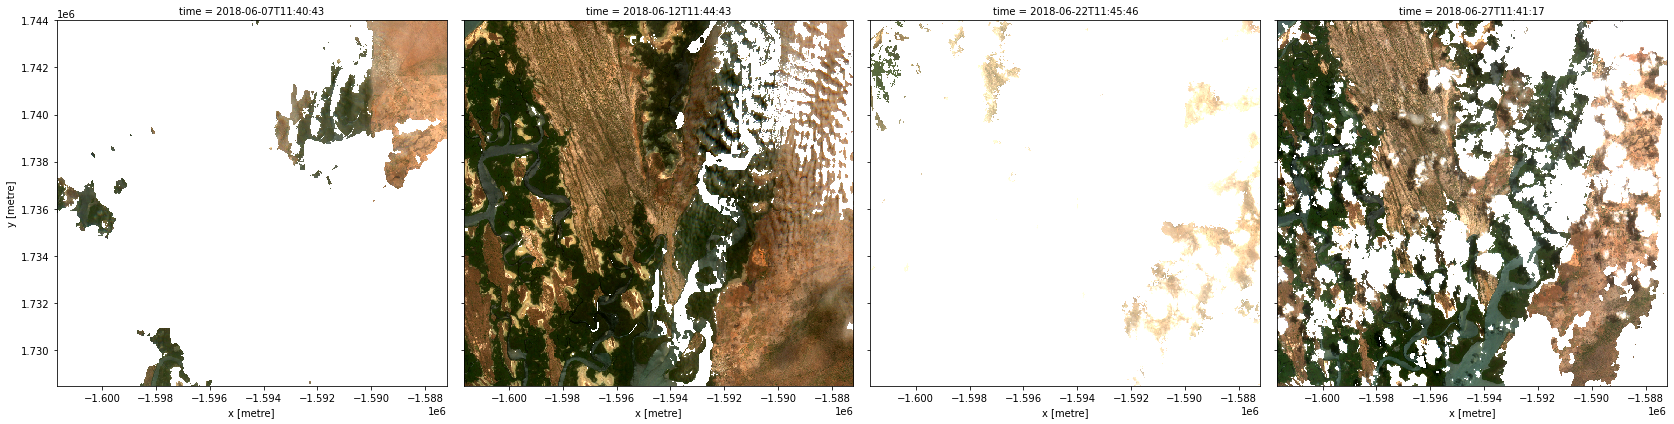

In [12]:
# Plot single observation
rgb(s2, index=[1,2,4,5])

## Lazy loading with Dask
Rather than load data directly - which can take a long time and large amounts of memory - all datacube data can be lazy loaded using Dask. This can be a very useful approach for when you need to load large amounts of data without crashing your analysis, or if you want to subsequently scale your analysis by distributing tasks in parallel across multiple workers.

The load_ard function can be easily adapted to lazily load data rather than loading it into memory by providing a dask_chunks parameter using either the explicit or query syntax. The minimum required to lazily load data is `dask_chunks={}`, but chunking can also be performed spatially (e.g. `dask_chunks={'x': 3000, 'y': 3000}`) or by time (e.g. `dask_chunks={'time': 1}`) depending on the analysis being conducted.
See the [Dask documentation](https://docs.dask.org/en/latest/array-chunks.html) for more information about setting chunk sizes.

To learn more about lazy-loading with Dask, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

In [13]:
# Load available data from both S2 datasets
s2 = load_ard(dc=dc,
              products=['s2_l2a'], 
              resolution=(-20, 20),
              dask_chunks={'time':1,'x':500,'y':500},
              **query)

# Print output data
print(s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 19 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 19, x: 724, y: 776)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-02T11:39:20 ... 2018-08-31T11:...
  * y            (y) float64 1.744e+06 1.744e+06 ... 1.729e+06 1.728e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.587e+06 -1.587e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-20'